In [355]:
import pandas as pd
import numpy as np

In [356]:
import pandas as pd
import numpy as np

In [357]:
import pandas as pd
import numpy as np

In [358]:
import pandas as pd
import numpy as np

In [359]:
!wget "https://archive.ics.uci.edu/static/public/222/bank+marketing.zip" -O "../dataset/data.zip"

--2024-10-23 10:38:55--  https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘../dataset/data.zip’

../dataset/data.zip     [      <=>           ] 999.85K   847KB/s    in 1.2s    

2024-10-23 10:38:56 (847 KB/s) - ‘../dataset/data.zip’ saved [1023843]



In [360]:
!unzip -o "../dataset/data.zip" -d "../dataset/"

Archive:  ../dataset/data.zip
 extracting: ../dataset/bank.zip     
 extracting: ../dataset/bank-additional.zip  


In [361]:
!unzip -o "../dataset/bank.zip" -d "../dataset/"

Archive:  ../dataset/bank.zip
  inflating: ../dataset/bank-full.csv  
  inflating: ../dataset/bank-names.txt  
  inflating: ../dataset/bank.csv     


In [362]:
df = pd.read_csv("../dataset/bank-full.csv", sep=';')

In [363]:
columns = ['age', 'job', 'marital', 'education', 'balance', 'housing','contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y']

In [364]:
df=df[columns]
len(df)

45211

In [365]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
balance      0
housing      0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [366]:
df[::10]

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
10,41,admin.,divorced,secondary,270,yes,unknown,5,may,222,1,-1,0,unknown,no
20,28,blue-collar,married,secondary,723,yes,unknown,5,may,262,1,-1,0,unknown,no
30,57,technician,married,secondary,839,no,unknown,5,may,225,1,-1,0,unknown,no
40,44,services,divorced,secondary,2586,yes,unknown,5,may,160,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45170,19,student,single,primary,245,no,telephone,10,nov,98,2,110,2,other,no
45180,66,retired,married,secondary,3409,no,cellular,15,nov,414,2,27,6,failure,no
45190,32,blue-collar,married,secondary,136,no,cellular,16,nov,206,1,188,3,success,yes
45200,38,technician,married,secondary,557,yes,cellular,16,nov,1556,4,-1,0,unknown,yes


In [367]:
df.y=(df.y=="yes").astype(int)
df.y.value_counts()

y
0    39922
1     5289
Name: count, dtype: int64

In [368]:
from sklearn.model_selection import train_test_split

In [369]:
df_full_train, df_test = train_test_split(df, test_size=0.20, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [370]:
len(df_train), len(df_val), len(df_test)

(27126, 9042, 9043)

# Question 1: ROC AUC feature importance

In [371]:
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

In [372]:
del df_train["y"]
del df_val["y"]
del df_test["y"]

In [373]:
numerical=['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [374]:
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [375]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [376]:
import matplotlib.pyplot as plt
import seaborn as sns

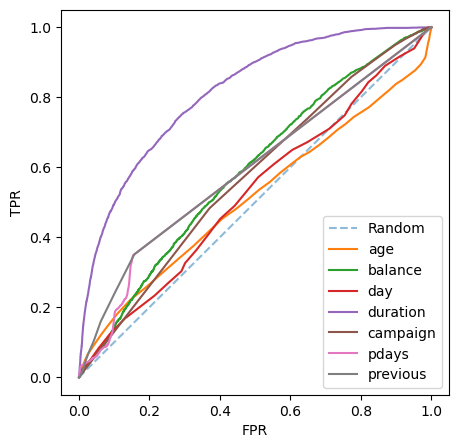

In [377]:
results_dict = {}
plt.figure(figsize=(5,5))
plt.plot ([0,1], [0,1], label = 'Random', linestyle = '--', alpha=0.5)
for col in numerical:
    fpr, tpr, thresholds = roc_curve(y_true=y_train, y_score=df_train[col])
    auc_score_result = auc(fpr, tpr)
    if (auc_score_result < 0.5):
        fpr, tpr, thresholds = roc_curve(y_true=y_train, y_score=-df_train[col])        
        auc_score_result = auc(fpr,tpr)
    plt.plot(fpr,tpr, label =col)        
    results_dict[col]=auc_score_result

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()



In [378]:
sorted_aucs = sorted(results_dict.items(), key=lambda item: item[1], reverse=True)
feature_with_higher_auc = {sorted_aucs[0][0]}
feature_with_higher_auc

{'duration'}

ANSWER Q1

In [379]:
print (f'The numerical value with highest AUC is \'{feature_with_higher_auc}\' ')


The numerical value with highest AUC is '{'duration'}' 


# Question 2: Training the model

In [380]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [381]:
def train_and_get_auc(df_train, y_train, df_val, y_val, model):
    dv = DictVectorizer()
    _train_dicts = df_train.to_dict(orient='records')
    _X_train = dv.fit_transform(_train_dicts)
    model.fit(_X_train, y_train)
    _val_dicts = df_val.to_dict(orient='records')    
    _X_val = dv.transform(_val_dicts)
    y_pred_proba = model.predict_proba(_X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred_proba).round(3)
    return auc, y_pred_proba


In [382]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
auc, y_pred_proba =train_and_get_auc(df_train, y_train, df_val, y_val, model)
auc

0.9

ANSWER Q2:

In [383]:
print (f'The AUC of the model in the validation dataset is {auc}')

The AUC of the model in the validation dataset is 0.9


# Question 3: Precision and Recall

In [384]:
def evaluate_model_with_threshold(y_val, y_pred_proba, t):
    actual_positive = (y_val==1)
    actual_negative = (y_val==0)
    predict_positive = (y_pred_proba >=t)
    predict_negative = (y_pred_proba <t)

    tp = (predict_positive & actual_positive).sum()
    fp = (predict_positive & actual_negative).sum()
    tn = (predict_negative & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()  

    if tp+fp>0:
        precision = tp/(tp+fp)
    else:       
        precision = np.nan

    if tp+fn>0:
        recall = tp/(tp+fn)
    else:       
        recall = np.nan     
    return  precision, recall

In [385]:
thresholds = np.linspace(0.0,1.0, num=101)

In [386]:
results = []
for t in thresholds:
    precision, recall = evaluate_model_with_threshold(y_val, y_pred_proba, t)
    results.append((t, precision, recall))

In [387]:
evaluation_df = pd.DataFrame(results, columns = ['threshold', 'precision', 'recall'])
evaluation_df.head()

,threshold,precision,recall
0,0.00,0.121433,1.000000
1,0.01,0.135112,0.996357
2,0.02,0.158866,0.995446
3,0.03,0.186513,0.989982
4,0.04,0.219688,0.973588


In [388]:
max_precision_index = evaluation_df['precision'].idxmax()
max_precision_threshold = evaluation_df['threshold'].iloc[max_precision_index]
max_precision_value = evaluation_df['precision'].iloc[max_precision_index]
print(f"El threshold que da la mayor precisión es: {max_precision_threshold} con precisión: {max_precision_value}")

El threshold que da la mayor precisión es: 0.9 con precisión: 0.7307692307692307


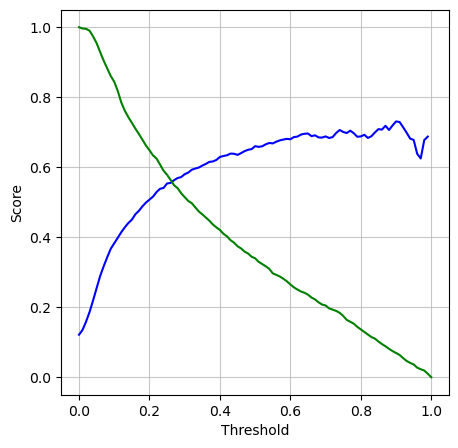

In [389]:
plt.figure(figsize=(5,5))
plt.plot(evaluation_df['threshold'], evaluation_df['precision'], label='Precision', color='blue')
plt.plot(evaluation_df['threshold'], evaluation_df['recall'], label='Recall', color='green')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.grid(alpha=0.7)

In [390]:
evaluation_df['difference'] = abs(evaluation_df['precision'] - evaluation_df['recall'])
result_matrix = evaluation_df[evaluation_df.threshold!=1.0]
min_difference_index = result_matrix['difference'].idxmin()
interception_threshold=result_matrix.iloc[min_difference_index]['threshold']
interception_threshold

0.26

Anwer Q3

In [391]:
print(f'The precision and recall curves intercept at the threshold {interception_threshold}')

The precision and recall curves intercept at the threshold 0.26


# Question 4: F1 Score

In [ ]:
evaluation_df['f1'] = 2*((evaluation_df.precision*evaluation_df.recall)/(evaluation_df.precision+evaluation_df.recall))

In [ ]:
max_f1_index = evaluation_df['f1'].idxmax()
threshold_max_f1 = evaluation_df.iloc[max_f1_index]["threshold"]

ANSWER Q4:

In [ ]:
print(f'F1 is maximal on the threshold: {threshold_max_f1}')

# Question 5: 5-Fold CV


In [ ]:
from sklearn.model_selection import KFold

In [ ]:
kfold =KFold(n_splits=5, shuffle=True, random_state=1)

In [ ]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
scores = []
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.y.values
    y_val = df_val.y.values

    del df_train["y"]
    del df_val["y"]

    auc, y_pred_proba = train_and_get_auc(df_train, y_train, df_val, y_val, model)
    scores.append(auc)

In [ ]:
scores

In [ ]:
std_scores = np.std(scores)
std_scores

In [ ]:
options_for_answer = [0.0001, 0.006, 0.06, 0.26]
closest_number_to_std = min(options_for_answer, key=lambda x: abs(x - std_scores))
closest_number_to_std

ANSWER Q5

In [ ]:
print (f'The standard deviation of the AUCs is: {closest_number_to_std}')

# Question 6: Hyperparameter Tuning

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
scores=[]
for c in tqdm([0.000001, 0.001, 1]):
    kfold =KFold(n_splits=5, shuffle=True, random_state=1)
    model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = df_train.y.values
        y_val = df_val.y.values
    
        del df_train["y"]
        del df_val["y"]
    
        auc, y_pred_proba = train_and_get_auc(df_train, y_train, df_val, y_val, model)
        scores.append((c,auc))
scores

In [ ]:
scores_df = pd.DataFrame(scores, columns = ['c','auc'])
scores_df

In [ ]:
c_auc_df = scores_df.groupby('c')['auc'].mean().reset_index()
c_auc_df

In [ ]:
max_auc_index = c_auc_df['auc'].idxmax()
best_c = c_auc_df.iloc[max_auc_index]['c']

ANSWER Q6

In [ ]:
print(f'The c which leads to the best mean score is: {best_c}')